

---
# Biostat 682 — Lecture 12: Variational Inference vs MCMC (NUTS) vs CAVI — Bayesian Linear Regression Demo

This Colab-ready notebook simulates a Bayesian linear regression dataset, then fits the **same model** using:
1. **MCMC** (NUTS in PyMC) — reference.
2. **Variational Inference** (ADVI in PyMC) — mean-field approximation.
3. **Coordinate Ascent Variational Inference (CAVI)** — closed-form updates for conjugate BLR.

We compare posterior means/variances, runtimes, and posterior predictive performance.


In [1]:

# If running on Colab, uncomment the following:
# %pip install -q pymc arviz numpy scipy matplotlib


In [2]:

import time
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
from scipy.stats import norm

rng = np.random.default_rng(42)
np.set_printoptions(suppress=True, precision=4)



## 1) Simulate data (standardized)
We generate a synthetic dataset with known coefficients, then standardize \(X\) and \(y\).


In [3]:
n, p = 1000, 8
beta_true = np.array([1.5, -1.0, 0.5] + [0.0]*(p-3))
sigma_true = 1.0
# Simulate correlated data
# Number of correlated features
rho = 0.5  # Correlation coefficient
cov_matrix = np.full((p, p), rho)
np.fill_diagonal(cov_matrix, 1)

X = rng.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n)

# Use beta_true to simulate y
y = X @ beta_true + rng.normal(scale=sigma_true, size=n)

# Calculate R-squared for simulated data
y_pred_true = X @ beta_true
ssr = np.sum((y_pred_true - y.mean())**2)
sst = np.sum((y - y.mean())**2)
r_squared_simulated = ssr / sst

# standardize X and y
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()

n, p, beta_true, sigma_true, r_squared_simulated

(1000,
 8,
 array([ 1.5, -1. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ]),
 1.0,
 np.float64(0.6870969860575586))


## 2) Model (shared by all methods)

- Likelihood: \( \pi(y \mid X,\beta,\sigma^2) = \mathcal{N}(y; X\beta, \sigma^2 I) \)
- Priors: \( \pi(\beta) = \mathcal{N}(0, \tau^2 I) \), \( \pi(\sigma) = \mathrm{HalfNormal}(1) \)

We’ll use \(\tau=10\) for weakly-informative shrinkage.



## 3) One PyMC model → run **MCMC (NUTS)** and **VI (ADVI)**


In [4]:

tau = 10.0

with pm.Model() as blr:
    beta  = pm.Normal("beta", mu=np.zeros(p), sigma=tau, shape=p)
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    y_like = pm.Normal("y", mu=pm.math.dot(X, beta), sigma=sigma, observed=y)

    # --- MCMC (NUTS) ---
    t0 = time.time()
    idata_mcmc = pm.sample(draws=1500, tune=1000, chains=4, target_accept=0.9,
                           random_seed=42, return_inferencedata=True, progressbar=True)
    mcmc_time = time.time() - t0

    # --- VI (ADVI) ---
    t0 = time.time()
    approx = pm.fit(n=20000, method="advi", random_seed=42)
    idata_vi = approx.sample(2000)
    vi_time = time.time() - t0

mcmc_time, vi_time


Output()

Output()

(24.611879587173462, 4.897617340087891)


## 4) Closed-form **CAVI** for conjugate BLR
We derive $q(\beta)=\mathcal{N}(m,\Sigma)$ and $q(\sigma^{-2})=\mathrm{G}(a', b')$ under mean-field factorization.


In [5]:

def cavi_blr(X, y, tau2=100.0, a=1.0, b=1.0, max_iter=1000, tol=1e-6):
    n, p = X.shape
    XtX = X.T @ X
    Xty = X.T @ y

    # Initialize
    a_p = a + n / 2.0
    m = np.zeros(p)
    Sigma = np.eye(p)
    b_p = b + 0.5 * (y @ y)  # crude init

    for _ in range(max_iter):
        inv_sigma2_mean = a_p / b_p
        # q(beta): Normal(m, Sigma)
        Sigma_new = np.linalg.inv(inv_sigma2_mean * XtX + (1.0 / tau2) * np.eye(p))
        m_new = Sigma_new @ (inv_sigma2_mean * Xty)

        # E[||y - X beta||^2] under q(beta)
        sse = np.sum((y - X @ m_new) ** 2) + np.trace(XtX @ Sigma_new)

        # q(sigma^2): InvGamma(a', b')
        b_p_new = b + 0.5 * sse

        if np.max(np.abs(m_new - m)) < tol and abs(b_p_new - b_p) < tol:
            m, Sigma, b_p = m_new, Sigma_new, b_p_new
            break

        m, Sigma, b_p = m_new, Sigma_new, b_p_new

    return m, Sigma, a_p, b_p

def vb_ppc_sample(Xnew, m, Sigma, a_p, b_p, draws=1000, rng=None):
    """
    Draw posterior predictive samples:
      beta ~ N(m, Sigma), sigma^2 ~ InvGamma(a_p, b_p),
      y* ~ N(X* beta, sigma^2 I)
    Returns array of shape (draws, n_new).
    """
    rng = np.random.default_rng(None if rng is None else rng)
    # Inverse-Gamma(a,b): sample as 1 / Gamma(shape=a, rate=b) -> numpy uses 'scale' = 1/rate
    gamma = rng.gamma(shape=a_p, scale=1.0 / b_p, size=draws)
    sigma2 = 1.0 / gamma
    # beta draws
    L = np.linalg.cholesky(Sigma)
    z = rng.normal(size=(draws, m.size))
    beta_draws = m[None, :] + z @ L.T
    # means
    mu = beta_draws @ Xnew.T  # (draws, n_new)
    # add noise
    eps = rng.normal(size=mu.shape) * np.sqrt(sigma2)[:, None]
    return mu + eps

import time
t0 = time.time()
m, Sigma, a_p, b_p = cavi_blr(X, y, tau2=tau**2, a=1.0, b=1.0, max_iter=2000)

yrep = vb_ppc_sample(X, m, Sigma, a_p, b_p, draws=2000)  # (S, n_new)

ppc_mean_cavi = yrep.mean(axis=0)
ppc_sd_cavi   = yrep.std(axis=0)

cavi_time = time.time() - t0
cavi_time, a_p, b_p


(0.1918621063232422, 501.0, np.float64(158.0477184602696))

## 5) **CAVI**:  tracks the ELBO

Here’s a single-function CAVI implementation for Bayesian linear regression that tracks the ELBO (using the precision $\sigma^{-2}$. It returns the variational parameters and an ELBO trajectory.

In [6]:
from scipy.special import psi, gammaln  # digamma = psi

def cavi_blr_with_elbo(X, y, tau2=100.0, a=1.0, b=1.0, max_iter=1000, tol=1e-6):
    """
    Coordinate Ascent Variational Inference (CAVI) for Bayesian Linear Regression
    with ELBO tracking, using the precision parameterization λ = 1/σ^2.

    Model:
      y | X, beta, λ ~ N(X beta, (1/λ) I)
      beta ~ N(0, tau2 I)
      λ ~ Gamma(a, b)     # shape-rate parameterization

    Variational family (mean-field):
      q(beta) = N(m, Σ)
      q(λ)    = Gamma(a', b')

    Args:
      X : (n, p) design matrix
      y : (n,) response vector
      tau2 : prior variance for beta (scalar)
      a, b : prior Gamma(shape=a, rate=b) for λ
      max_iter : max CAVI iterations
      tol : stopping tolerance on parameter change

    Returns:
      m        : (p,) mean of q(beta)
      Sigma    : (p, p) covariance of q(beta)
      a_p, b_p : shape and rate of q(λ)
      elbo_vals: list of ELBO values across iterations
    """
    n, p = X.shape
    XtX = X.T @ X
    Xty = X.T @ y

    # Initialize variational parameters
    a_p = a + n / 2.0
    m    = np.zeros(p)
    Sigma = np.eye(p)
    # crude init for b' using y'y (acts like initial residual scale)
    b_p  = b + 0.5 * (y @ y)

    elbo_vals = []

    for _ in range(max_iter):
        # E_q[λ] with current (a', b')
        E_lambda = a_p / b_p

        # q(beta): Σ = [E[λ] X^T X + (1/tau2) I]^{-1},  m = Σ E[λ] X^T y
        Sigma_new = np.linalg.inv(E_lambda * XtX + (1.0 / tau2) * np.eye(p))
        m_new     = Sigma_new @ (E_lambda * Xty)

        # E_q[||y - X beta||^2] = ||y - X m||^2 + tr(X^T X Σ)
        sse = np.sum((y - X @ m_new) ** 2) + np.trace(XtX @ Sigma_new)

        # q(λ): Gamma(a', b'),  with a' fixed and b' updated
        b_p_new = b + 0.5 * sse

        # --- ELBO (precision form) ---
        # Expectations
        E_log_lambda = psi(a_p) - np.log(b_p_new)
        E_lambda     = a_p / b_p_new
        E_beta_sq    = m_new @ m_new + np.trace(Sigma_new)

        # Terms of ELBO
        # E[log p(y|beta,λ)]
        term_like = -(n/2)*np.log(2*np.pi) + (n/2)*E_log_lambda - 0.5*E_lambda*sse
        # E[log p(beta)]
        term_prior_beta = -(p/2)*np.log(2*np.pi*tau2) - (1.0/(2*tau2))*E_beta_sq
        # E[log p(λ)]
        term_prior_lambda = a*np.log(b) - gammaln(a) + (a-1)*E_log_lambda - b*E_lambda
        # - E[log q(beta)]
        sign, logdet = np.linalg.slogdet(2*np.pi*np.e*Sigma_new)
        term_q_beta = -0.5*logdet
        # - E[log q(λ)]
        term_q_lambda = a_p*np.log(b_p_new) - gammaln(a_p) + (a_p-1)*E_log_lambda - b_p_new*E_lambda

        elbo = term_like + term_prior_beta + term_prior_lambda - term_q_beta - term_q_lambda
        elbo_vals.append(float(elbo))
        # --- end ELBO ---

        # Convergence check (parameters)
        if np.max(np.abs(m_new - m)) < tol and abs(b_p_new - b_p) < tol:
            m, Sigma, b_p = m_new, Sigma_new, b_p_new
            break

        m, Sigma, b_p = m_new, Sigma_new, b_p_new

    return m, Sigma, a_p, b_p, elbo_vals


Usage Example

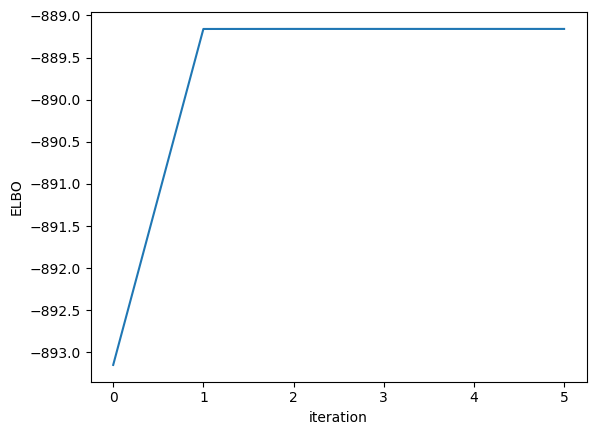

In [7]:
# X: (n,p), y: (n,)
m, Sigma, a_p, b_p, elbo_vals = cavi_blr_with_elbo(X, y, tau2=100.0, a=1.0, b=1.0)
# ELBO curve to check monotone ascent:
import matplotlib.pyplot as plt
plt.plot(elbo_vals); plt.xlabel("iteration"); plt.ylabel("ELBO"); plt.show()


## 6) Summaries: posterior means and variances


In [8]:

# MCMC summaries
post_mcmc = idata_mcmc.posterior
beta_mcmc = post_mcmc["beta"].stack(sample=("chain","draw"))
beta_mcmc_mean = beta_mcmc.mean("sample").values
beta_mcmc_var  = beta_mcmc.var("sample").values
sigma_mcmc = post_mcmc["sigma"].stack(sample=("chain","draw"))
sigma_mcmc_mean = sigma_mcmc.mean("sample").values
sigma_mcmc_var  = sigma_mcmc.var("sample").values

# VI (ADVI) summaries
post_vi = idata_vi.posterior
beta_vi = post_vi["beta"].stack(sample=("chain","draw"))
beta_vi_mean = beta_vi.mean("sample").values
beta_vi_var  = beta_vi.var("sample").values
sigma_vi = post_vi["sigma"].stack(sample=("chain","draw"))
sigma_vi_mean = sigma_vi.mean("sample").values
sigma_vi_var  = sigma_vi.var("sample").values

# CAVI (analytic moments)
beta_cavi_mean = m
beta_cavi_var_diag = np.diag(Sigma)
sigma2_cavi_mean = b_p / (a_p - 1) if a_p > 1 else np.nan  # E[sigma^2] for IG(a', b')

print("Times (s) — MCMC: %.2f, VI: %.2f, CAVI: %.4f" % (mcmc_time, vi_time, cavi_time))
print("\nbeta means (first 5):")
print("MCMC:", beta_mcmc_mean[:5])
print("ADVI  :", beta_vi_mean[:5])
print("CAVI:", beta_cavi_mean[:5])


Times (s) — MCMC: 24.61, VI: 4.90, CAVI: 0.1919

beta means (first 5):
MCMC: [ 0.8217 -0.5714  0.2588  0.0034 -0.0184]
ADVI  : [ 0.8186 -0.5772  0.2599  0.0039 -0.017 ]
CAVI: [ 0.8214 -0.5715  0.2587  0.0034 -0.0181]



## 6) Visual comparison (posteriors for a few coefficients)


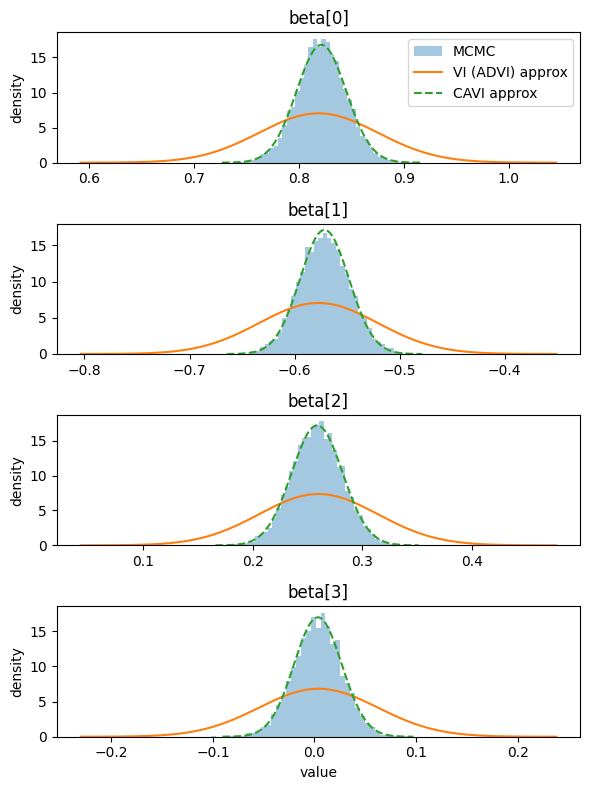

In [9]:

from scipy.stats import norm

idxs = [0, 1, 2, 3]  # pick a few coefficients

fig, axes = plt.subplots(len(idxs), 1, figsize=(6, 8))
for ax, j in zip(axes, idxs):
    # MCMC KDE (histogram as quick proxy)
    ax.hist(beta_mcmc.isel(beta_dim_0=j).values, bins=40, density=True, alpha=0.4, label='MCMC')
    # VI Gaussian approx (mean/var from VI)
    mu_vi = beta_vi_mean[j]
    sd_vi = np.sqrt(beta_vi_var[j])
    grid = np.linspace(mu_vi - 4*sd_vi, mu_vi + 4*sd_vi, 400)
    ax.plot(grid, norm.pdf(grid, loc=mu_vi, scale=sd_vi), label='VI (ADVI) approx')
    # CAVI Gaussian approx
    mu_cv = beta_cavi_mean[j]
    sd_cv = np.sqrt(beta_cavi_var_diag[j])
    grid2 = np.linspace(mu_cv - 4*sd_cv, mu_cv + 4*sd_cv, 400)
    ax.plot(grid2, norm.pdf(grid2, loc=mu_cv, scale=sd_cv), linestyle='--', label='CAVI approx')
    ax.set_title(f"beta[{j}]")
    ax.set_ylabel("density")
axes[-1].set_xlabel("value")
axes[0].legend(loc='best')
plt.tight_layout()
plt.show()



## 7) Posterior predictive comparison
We compare predictive RMSE using posterior predictive draws.


In [10]:
with blr:
  ppc_mcmc = pm.sample_posterior_predictive(idata_mcmc, var_names=["y"], return_inferencedata=False)
  ppc_vi = pm.sample_posterior_predictive(idata_vi, var_names=["y"], return_inferencedata=False)

yrep_mcmc = np.asarray(ppc_mcmc["y"])  # (S, n)
yrep_vi   = np.asarray(ppc_vi["y"])    # (S, n)

# In-sample RMSE (use y as a 1D array)
y_vec = np.asarray(y).ravel()
rmse_mcmc = np.sqrt(np.mean((yrep_mcmc.mean(axis=0) - y_vec)**2))
rmse_advi   = np.sqrt(np.mean((yrep_vi.mean(axis=0)   - y_vec)**2))
rmse_cavi   = np.sqrt(np.mean((ppc_mean_cavi - y_vec)**2))

print("RMSE (MCMC):", rmse_mcmc)
print("RMSE (ADVI):", rmse_advi)
print("RMSE (CAVI):", rmse_cavi)




Output()

Output()

RMSE (MCMC): 0.6251286247702166
RMSE (ADVI): 0.8218889226394703
RMSE (CAVI): 0.558716915497809



## 8) Takeaways
- **Speed**: ADVI and CAVI are much faster than MCMC; CAVI is the fastest since it has the closed-form for conjugate BLR.
- **Uncertainty**: ADVI may **underestimate** or **overestimate** posterior variance relative to MCMC.
- **Means**: Often very close across methods.
- **Practice**: Use VI (or CAVI) to initialize MCMC and for large-scale problems; validate on subsets with MCMC.
